# Introduction

The Johnson-Lindenstrauss lemma is a mathematical theorem that states that any high dimensional dataset can be randomly projected into a lower dimensional Euclidean space while controlling the distortion in the pairwise distances. In this lab, we will explore the theoretical bounds of the Johnson-Lindenstrauss lemma for embedding with random projections and validate it empirically using Python scikit-learn.

# Theoretical Bounds

The first step is to explore the theoretical bounds of the **Johnson–Lindenstrauss lemma**.
We will plot the minimum number of dimensions required to guarantee an $\varepsilon$-embedding for an increasing number of samples $n_{\text{samples}}$.

The distortion introduced by a random projection $p$ is asserted by the fact that $p$ is defining an $\varepsilon$-embedding with good probability, as defined by:

$$
(1 - \varepsilon)\,\lVert u - v \rVert^2
\;<\; \lVert p(u) - p(v) \rVert^2
\;<\; (1 + \varepsilon)\,\lVert u - v \rVert^2
$$

Where $u$ and $v$ are any rows taken from a dataset of shape
$(n_{\text{samples}}, n_{\text{features}})$, and $p$ is a projection by a random Gaussian
$\mathcal{N}(0, 1)$ matrix of shape $(n_{\text{components}}, n_{\text{features}})$
(or a sparse Achlioptas matrix).


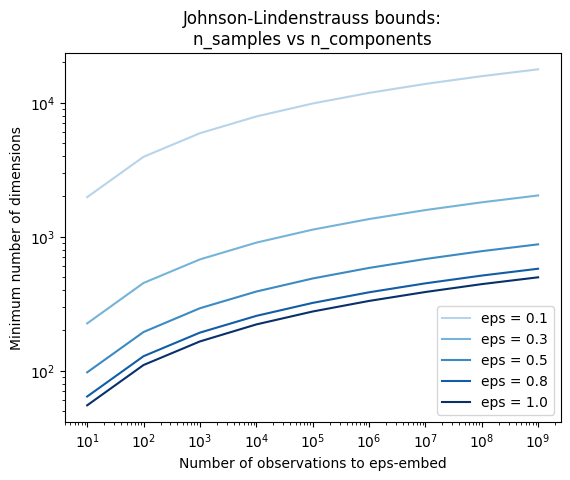

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.random_projection import johnson_lindenstrauss_min_dim

# range of admissible distortions
eps_range = np.linspace(0.1, 0.99, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(eps_range)))

# range of number of samples (observation) to embed
n_samples_range = np.logspace(1, 9, 9)

plt.figure()
for eps, color in zip(eps_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples_range, eps=eps)
    plt.loglog(n_samples_range, min_n_components, color=color)

plt.legend([f"eps = {eps:0.1f}" for eps in eps_range], loc="lower right")
plt.xlabel("Number of observations to eps-embed")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_samples vs n_components")
plt.show()

# Theoretical Bounds (cont'd)

The second plot shows that an increase of the admissible distortion **eps** allows us to reduce the minimal number of dimensions **n_components** for a given number of samples **n_samples**.

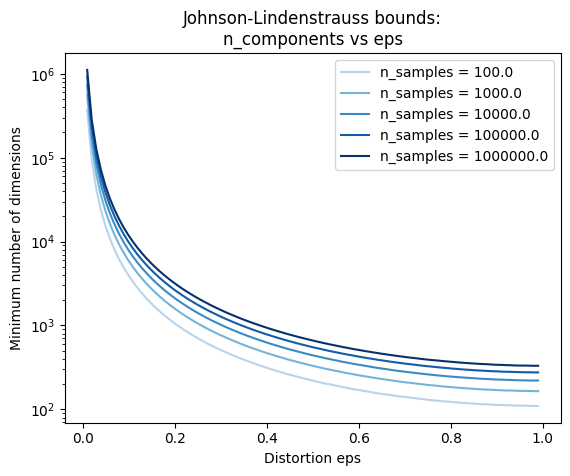

In [2]:
# range of admissible distortions
eps_range = np.linspace(0.01, 0.99, 100)

# range of number of samples (observation) to embed
n_samples_range = np.logspace(2, 6, 5)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(n_samples_range)))

plt.figure()
for n_samples, color in zip(n_samples_range, colors):
    min_n_components = johnson_lindenstrauss_min_dim(n_samples, eps=eps_range)
    plt.semilogy(eps_range, min_n_components, color=color)

plt.legend([f"n_samples = {n}" for n in n_samples_range], loc="upper right")
plt.xlabel("Distortion eps")
plt.ylabel("Minimum number of dimensions")
plt.title("Johnson-Lindenstrauss bounds:\nn_components vs eps")
plt.show()

# Empirical Validation

The next step is to validate the Johnson-Lindenstrauss bounds empirically on the 20 newsgroups text document dataset or on the digits dataset. We will use the 20 newsgroups dataset and project 300 documents with 100k features in total using a sparse random matrix to smaller Euclidean spaces with various values for the target number of dimensions **n_components**.

Embedding 300 samples with dim 130107 using various random projections
Projected 300 samples from 130107 to 300 in 0.161s
Random matrix with size: 1.293 MB
Mean distances rate: 1.09 (0.20)
Projected 300 samples from 130107 to 1000 in 0.406s
Random matrix with size: 4.317 MB
Mean distances rate: 0.99 (0.10)
Projected 300 samples from 130107 to 10000 in 4.170s
Random matrix with size: 43.296 MB
Mean distances rate: 0.99 (0.03)


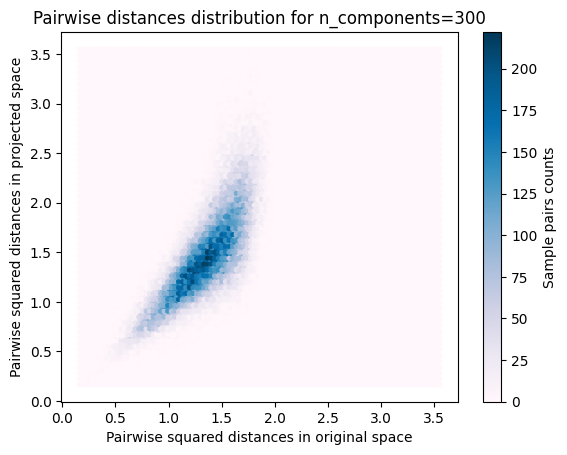

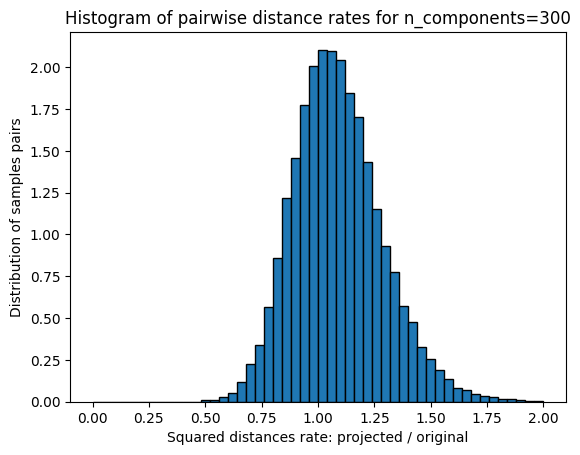

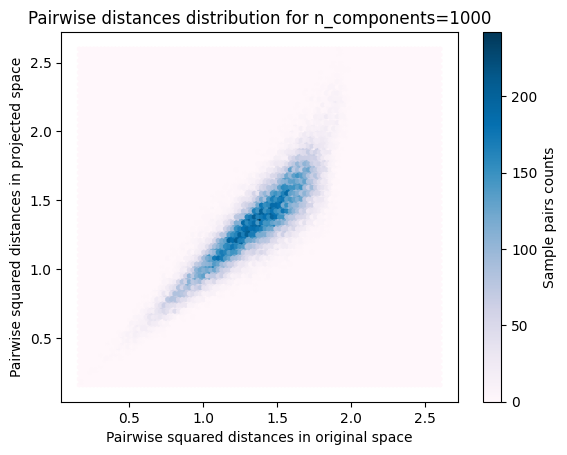

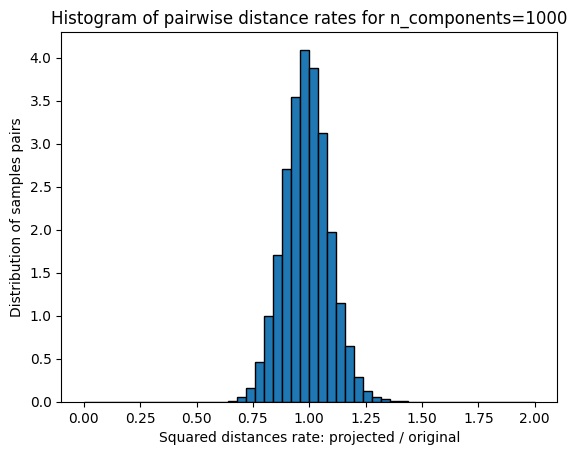

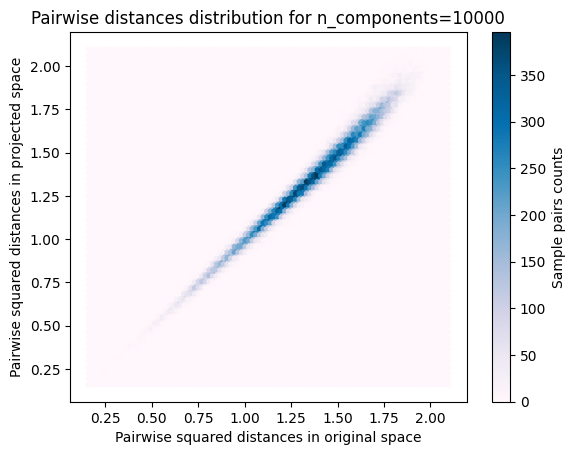

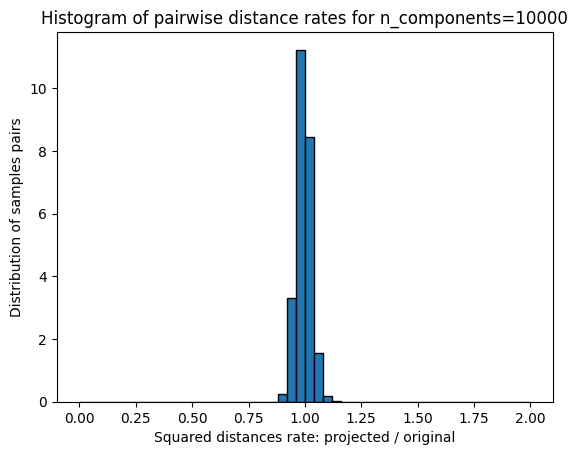

In [3]:
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.random_projection import SparseRandomProjection
from sklearn.metrics.pairwise import euclidean_distances

data = fetch_20newsgroups_vectorized().data[:300]

n_samples, n_features = data.shape
print(f"Embedding {n_samples} samples with dim {n_features} using various random projections")

n_components_range = np.array([300, 1_000, 10_000])
dists = euclidean_distances(data, squared=True).ravel()

# select only non-identical samples pairs
nonzero = dists != 0
dists = dists[nonzero]

for n_components in n_components_range:
    t0 = time()
    rp = SparseRandomProjection(n_components=n_components)
    projected_data = rp.fit_transform(data)
    print(f"Projected {n_samples} samples from {n_features} to {n_components} in {time() - t0:0.3f}s")
    if hasattr(rp, "components_"):
        n_bytes = rp.components_.data.nbytes
        n_bytes += rp.components_.indices.nbytes
        print(f"Random matrix with size: {n_bytes / 1e6:0.3f} MB")

    projected_dists = euclidean_distances(projected_data, squared=True).ravel()[nonzero]

    plt.figure()
    min_dist = min(projected_dists.min(), dists.min())
    max_dist = max(projected_dists.max(), dists.max())
    plt.hexbin(
        dists,
        projected_dists,
        gridsize=100,
        cmap=plt.cm.PuBu,
        extent=[min_dist, max_dist, min_dist, max_dist],
    )
    plt.xlabel("Pairwise squared distances in original space")
    plt.ylabel("Pairwise squared distances in projected space")
    plt.title("Pairwise distances distribution for n_components=%d" % n_components)
    cb = plt.colorbar()
    cb.set_label("Sample pairs counts")

    rates = projected_dists / dists
    print(f"Mean distances rate: {np.mean(rates):.2f} ({np.std(rates):.2f})")

    plt.figure()
    plt.hist(rates, bins=50, range=(0.0, 2.0), edgecolor="k", density=True)
    plt.xlabel("Squared distances rate: projected / original")
    plt.ylabel("Distribution of samples pairs")
    plt.title("Histogram of pairwise distance rates for n_components=%d" % n_components)

# Summary

In this lab, we explored the theoretical bounds of the Johnson-Lindenstrauss lemma for embedding with random projections and validated it empirically using Python scikit-learn. We plotted the minimum number of dimensions required to guarantee an **eps-embedding** for an increasing number of samples **n_samples**. We also validated the Johnson-Lindenstrauss bounds empirically on the 20 newsgroups text document dataset or on the digits dataset. We projected 300 documents with 100k features in total using a sparse random matrix to smaller Euclidean spaces with various values for the target number of dimensions **n_components**. We can see that for low values of **n_components** the distribution is wide with many distorted pairs and a skewed distribution while for larger values of **n_components** the distortion is controlled and the distances are well preserved by the random projection.